In [1]:
import csv
import numpy as np
import os
import pandas as pd

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.preprocessing import normalize
from sklearn import preprocessing
import torch
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib import ticker
from scipy.stats import spearmanr
from torch.utils.tensorboard import SummaryWriter

from src.utils import Plotting 
from src.utils import Dataloader
from src.utils import EarlyStopping

import datetime

import seaborn as sns
from sklearn.metrics import mean_absolute_error


In [2]:
seed=999
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [3]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


In [4]:
fname="/gpfs/work/sharmas/mc-snow-data/Timeseries_data.csv"

In [83]:
df=pd.read_csv(fname)

In [84]:
df["tau"]=df["Lr"]/(df["Lr"]+df["Lc"])
df["Xc"]=df["Lc"]/df["Nc"]
d=df[['Lc','Nc','Lr','Nr','lwc0','rm','nu_gam','tau','Xc']].to_numpy()
time=df['time']
input_num=d.shape[-1]

In [85]:
timestep,dataset=Dataloader.create_dataset_updatefunc(d, time)

In [86]:
dataset.shape

(472092, 14)

In [87]:
means, sds, dataset=Dataloader.norm_data(dataset,1)

In [88]:
train_dataloader,val_dataloader,test_dataloader,train_dataset,val_dataset, test_dataset=Dataloader.dataset_transform(dataset)

In [89]:
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import torch.optim as optim

In [90]:
depth=input_num
class Network(nn.Module):

    def __init__(self,act):
        
        super().__init__()
       
        self.fc1 = nn.Linear(depth, 160)
        nn.init.kaiming_normal_(self.fc1.weight, mode='fan_out')
        self.b1 = nn.BatchNorm1d(160)
        self.fc2 = nn.Linear(160, 120)
        nn.init.kaiming_normal_(self.fc2.weight, mode='fan_out')
        self.b2 = nn.BatchNorm1d(120)
        self.fc3 = nn.Linear(120,60)
        nn.init.kaiming_normal_(self.fc3.weight, mode='fan_out')
        self.b3 = nn.BatchNorm1d(60)
        
        self.fc4 = nn.Linear(60,60)
        nn.init.kaiming_normal_(self.fc4.weight, mode='fan_out')
        self.fc5 = nn.Linear(60,30)
        nn.init.kaiming_normal_(self.fc5.weight, mode='fan_out')
        
        
        self.fc6 = nn.Linear(30,4)
        
        
        self.dropout = nn.Dropout(0.25)
        self.activation = act
        
    def forward(self,x,verbose=False):
    
        x=self.activation((self.fc1(x)))
        x = self.dropout(x)
        if verbose:
            print(x.shape)
        x=self.activation((self.fc2(x)))
        x = self.dropout(x)
        if verbose:
            print(x.shape)
        x=self.activation((self.fc3(x)))
        x = self.dropout(x)
        if verbose:
            print(x.shape)
        
        x=self.activation((self.fc4(x)))
        x = self.dropout(x)
        if verbose:
            print(x.shape)
            
        x=self.activation((self.fc5(x)))
        x = self.dropout(x)
        if verbose:
            print(x.shape)
  
        x=(self.fc6(x))
        if verbose:
            print(x.shape)
        
        return x

In [91]:
model = Network(nn.ReLU())
model.to(device)

Network(
  (fc1): Linear(in_features=9, out_features=160, bias=True)
  (b1): BatchNorm1d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=160, out_features=120, bias=True)
  (b2): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=120, out_features=60, bias=True)
  (b3): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=60, out_features=60, bias=True)
  (fc5): Linear(in_features=60, out_features=30, bias=True)
  (fc6): Linear(in_features=30, out_features=4, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (activation): ReLU()
)

In [92]:
    
def loss_function(outputs,pred,mode):
    #criterion=torch.nn.SmoothL1Loss(size_average=None,reduce=None,reduction='mean',beta=0.03)
    criterion=torch.nn.MSELoss()
    if mode=="train":
        writer.add_scalars("Training loss for moments", {'Lc':criterion(outputs[:,0],pred[:,0]),'Nc':criterion(outputs[:,1],pred[:,1]),'Nr':criterion(outputs[:,3],pred[:,3])}, j)
    
    
    if mode=='val':
        writer.add_scalars("Validation loss for moments", {'Lc':criterion(outputs[:,0],pred[:,0]),'Nc':criterion(outputs[:,1],pred[:,1]),'Nr':criterion(outputs[:,3],pred[:,3])}, j)
    
    Lc=(pred[0]*torch.from_numpy(sds[-4].reshape(1, -1)).to(device))+(torch.from_numpy(means[-4].reshape(1, -1)).to(device))
   
    Lr=(pred[2]*torch.from_numpy(sds[-2].reshape(1, -1)).to(device))+(torch.from_numpy(means[-2].reshape(1, -1)).to(device))
    
    mse_loss= criterion(outputs,pred) + criterion(Lc,(-Lr))
    return mse_loss
#optimizer = torch.optim.SGD(model.parameters(), lr=(1e-3))
#optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=(1e-4))

In [93]:
losses=[]
val_loss=[]
n_epochs=200
j=0
patience=10
log_dir = "runs/UFwith3/4M_0.25drp_relu_6L_mse_earlystopping/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
writer = SummaryWriter(log_dir)

early_stopping = EarlyStopping.EarlyStopping(patience=patience, verbose=True)
for epoch in range(n_epochs):  
    
    print(f'epoch {epoch}')
    
    running_loss = 0.0
    for i, data in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        j+=1
        inputs=data[:,1:input_num+1].to(device)
        outputs=data[:,input_num+1:].to(device)
        optimizer.zero_grad()
        
        preds = model(inputs)
        loss = loss_function(outputs,preds,mode='train')
        
        loss.backward()
        
        optimizer.step()
        running_loss += loss.item()* inputs.size(0)
        
        #num+= inputs.size(0)
        #losses.append (loss.item())
        writer.add_scalar("Training Loss", loss.item() , j)
    print(f'Loss: {running_loss/ len(train_dataset)}')
    losses.append(running_loss / len(train_dataset))
    writer.add_scalar("Loss/train", losses[epoch], epoch)
    with torch.no_grad():
        running_loss = 0.0
        for i, data in tqdm(enumerate(val_dataloader), total=len(val_dataloader)):
            inputs=data[:,1:input_num+1].to(device)
            outputs=data[:,input_num+1:].to(device)
            model.eval()

            yhat = model(inputs)
            loss_v = loss_function(outputs,yhat,mode="val")
            running_loss += loss_v.item()* inputs.size(0)
    
    print(f'Loss: {(running_loss/len(val_dataset))}')
    val_loss.append(running_loss / len(val_dataset))
    writer.add_scalars("Training/Validation", {'Training':losses[epoch],'Validation':val_loss[epoch]}, epoch)
    early_stopping(val_loss[epoch], model)
    
    if early_stopping.early_stop:
            print("Early stopping")
            break
            
model.load_state_dict(torch.load('checkpoint.pt'))
   
    
writer.close()

epoch 0


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.9201252102313334


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.5862957509454811
Validation loss decreased (inf --> 0.586296).  Saving model ...
epoch 1


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.3131960153740637


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.23102183350187827
Validation loss decreased (0.586296 --> 0.231022).  Saving model ...
epoch 2


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.1931382970268024


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.19742269568558957
Validation loss decreased (0.231022 --> 0.197423).  Saving model ...
epoch 3


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.17220988353441652


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.18496615999818722
Validation loss decreased (0.197423 --> 0.184966).  Saving model ...
epoch 4


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.16405474860400515


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.18205089667446733
Validation loss decreased (0.184966 --> 0.182051).  Saving model ...
epoch 5


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.15959062425179618


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.1754534130353955
Validation loss decreased (0.182051 --> 0.175453).  Saving model ...
epoch 6


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.15733744398614344


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.17425822393801008
Validation loss decreased (0.175453 --> 0.174258).  Saving model ...
epoch 7


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.1561231796677483


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.17319206669497123
Validation loss decreased (0.174258 --> 0.173192).  Saving model ...
epoch 8


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.15509406155585995


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.1748131203160108
EarlyStopping counter: 1 out of 10
epoch 9


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.15419608770592158


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.17525313868220524
EarlyStopping counter: 2 out of 10
epoch 10


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.15356566173751238


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.17516913425934572
EarlyStopping counter: 3 out of 10
epoch 11


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.15348984445244712


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.1731971159584586
EarlyStopping counter: 4 out of 10
epoch 12


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.15297330015793775


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.17014715285453133
Validation loss decreased (0.173192 --> 0.170147).  Saving model ...
epoch 13


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.15330476390545728


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.17185736916718247
EarlyStopping counter: 1 out of 10
epoch 14


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.1522767421678068


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.1701837202099679
EarlyStopping counter: 2 out of 10
epoch 15


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.15220832900513803


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.16974728458666907
Validation loss decreased (0.170147 --> 0.169747).  Saving model ...
epoch 16


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.15176190153310767


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.17076769815720208
EarlyStopping counter: 1 out of 10
epoch 17


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.1511766158996428


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.1692141804012286
Validation loss decreased (0.169747 --> 0.169214).  Saving model ...
epoch 18


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.15145746822461048


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.16962642799463953
EarlyStopping counter: 1 out of 10
epoch 19


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.151257196740329


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.17116699995339052
EarlyStopping counter: 2 out of 10
epoch 20


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.15122789517814805


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.16895860070868263
Validation loss decreased (0.169214 --> 0.168959).  Saving model ...
epoch 21


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.15127609963986835


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.17455765383803867
EarlyStopping counter: 1 out of 10
epoch 22


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.1508756535229821


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.1709185241732293
EarlyStopping counter: 2 out of 10
epoch 23


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.15100044074772268


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.16951056197430686
EarlyStopping counter: 3 out of 10
epoch 24


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.1503188112270984


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.17115416615174014
EarlyStopping counter: 4 out of 10
epoch 25


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.15070724987412443


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.17184824417424133
EarlyStopping counter: 5 out of 10
epoch 26


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.15107686626829683


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.16905736556690576
EarlyStopping counter: 6 out of 10
epoch 27


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.15043446115953962


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.17430837902207585
EarlyStopping counter: 7 out of 10
epoch 28


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.15044156766508465


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.16921036843833492
EarlyStopping counter: 8 out of 10
epoch 29


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.1502610334184418


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.16927017954953916
EarlyStopping counter: 9 out of 10
epoch 30


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.150425376800032


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.16932497818077324
EarlyStopping counter: 10 out of 10
Early stopping


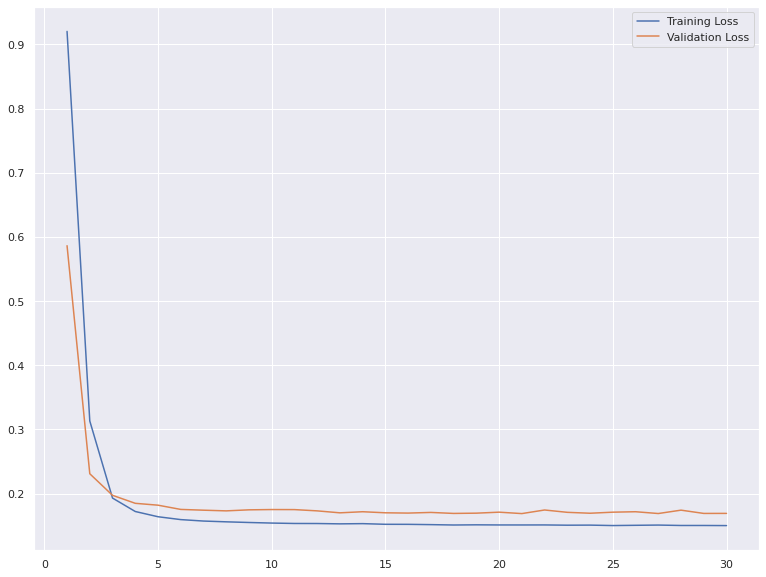

In [94]:
Plotting.plot_train(losses,val_loss,start=0,last=-1)

In [95]:
d = test_dataset[:]
inputs = d[2,1:input_num+1]
with torch.no_grad():
    print(model(inputs))
    traced_cell = torch.jit.trace(model, (inputs))
    
torch.jit.save(traced_cell, "UF_Net_MSE_3105.pth")

tensor([ 0.2254,  0.1996, -0.2225,  0.0088], device='cuda:0')


In [77]:
#model = torch.jit.load("UF_Net_Huber_0.035_2705.pth")
#model = torch.jit.load("UF_Net_MSE_3105.pth")
#model = torch.jit.load("UF_Net_2505.pth")
with torch.no_grad():
    d = test_dataset[:]

    inputs = d[:,1:input_num+1]
    targets = d[:,input_num+1:]
    model.eval()
    updates = model(inputs)
    

    inputs,updates, targets,time = inputs.to('cpu').numpy(), updates.to('cpu').numpy(), targets.to('cpu').numpy(),d[:,0].to('cpu').numpy()

In [78]:
inputs_orig= inputs* sds[0:input_num].reshape(1, -1) + means[:input_num].reshape(1, -1)
updates_orig= updates * sds[input_num:].reshape(1, -1) + means[input_num:].reshape(1, -1)

In [79]:
predictions_=[]
targets_=[]
timestep=[]
for i in range(len(d[:,0])-1):

    if d[i,0]<d[i+1,0]:
        timestep.append(d[i,0])
        predictions_.append((inputs_orig[i,0:4]+(updates_orig[i,:])*20))
        
        targets_.append(inputs_orig[i+1,0:4])


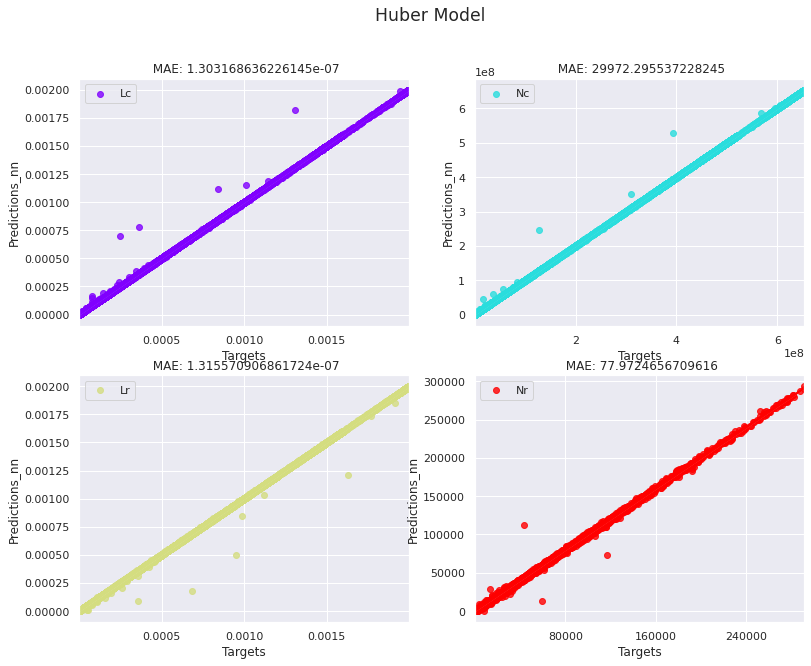

In [124]:
Plotting.plot_predictions_mm(np.asarray(targets_),np.asarray(predictions_),2,2,['Lc','Nc','Lr','Nr'],'Huber Model')

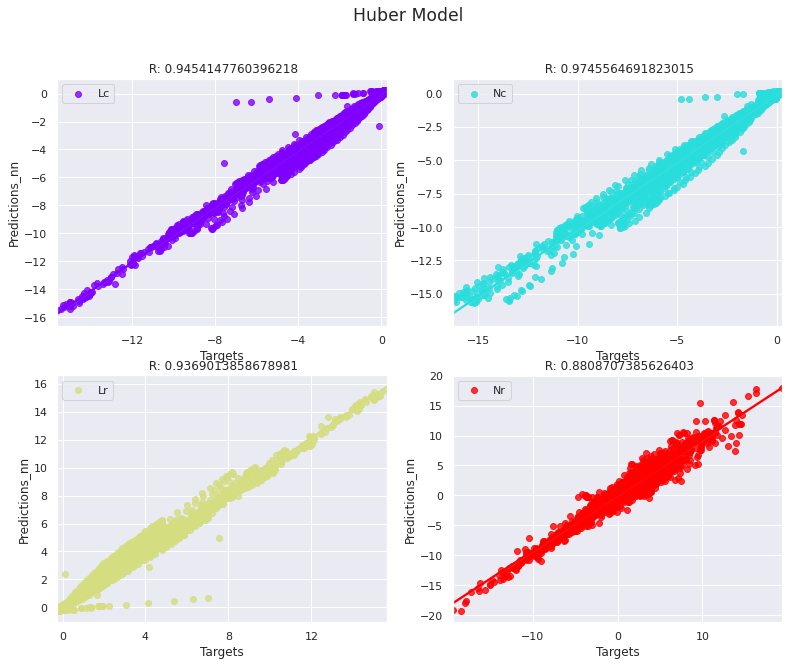

In [125]:
Plotting.plot_predictions(np.asarray(targets),np.asarray(updates),2,2,['Lc','Nc','Lr','Nr'],'Huber Model')

In [15]:
time=d[:,0]
sim_info=[]
initial_loc=0



for t in range (0,len(time)-1):
    if time[t+1]<time[t]:
        end_loc=t
        sim_duration=time[end_loc]-time[initial_loc]
        sim_info.append(np.array([initial_loc,end_loc,sim_duration.to('cpu').numpy()]))
        initial_loc= t+1
      

In [16]:
def remove_norm(arr,start=0,last=None):
    norm_arr= (arr * sds[start:last].reshape(1, -1)) + means[start:last].reshape(1, -1)
    return norm_arr
    

In [99]:
class simulation_forecast:
     def __init__(self, start_point,end_point):
        self.start_point=start_point
        self.end_point=end_point
        self.inputs=(d[start_point:end_point,1:input_num+1]).to(device)
        self.model_params=d[self.start_point,5:8].to('cpu').numpy()*sds[4:7].reshape(1, -1) + means[4:7].reshape(1, -1)
        self.targets_orig=d[self.start_point+1:self.end_point+1,1:5]
        self.predictions_orig=[]
        self.new_input=None
        self.preds=None

     def test(self):
        with torch.no_grad():
            model.eval()
            self.new_input=self.inputs[0,:]
          
            self.preds=model(self.new_input.reshape(1,-1))
            print(f"Input Before:{self.new_input}")
            self.moment_calc()
            
            for i in range (self.start_point+1,self.end_point):
                model.eval()
                self.new_input=self.new_input.astype(np.float32)
                self.new_input=(torch.from_numpy(self.new_input)).to(device)
                self.preds=model(self.new_input)
                self.new_input=self.new_input.reshape(input_num)
                self.moment_calc()
               
             
                
     def moment_calc(self):
        #self.new_input=(torch.from_numpy(self.new_input.reshape(input_num))[:]).to(device)
        self.update_calc()
       
        self.input_calc()
        
        predictions_orig_=self.new_input+(self.preds*20.0)
        
        self.check_predictions(predictions_orig_)
        
        #print(f"Predictions:{predictions_orig_}")
        
        
        
                
     def update_calc(self):
        self.preds=(torch.cat((self.preds[:,0:2],self.preds[:,2].reshape(-1,1),self.preds[:,3].reshape(-1,1)),1)).to('cpu').numpy()#Normalized
        
       
        self.preds= remove_norm(self.preds,input_num)#Un-normalize
        self.preds=self.preds.reshape(-1,)
       
        self.preds=((min(self.preds[0],0)),(min(self.preds[1],0)),(max(self.preds[2],0)),(self.preds[3]))
        #self.preds=(self.preds[0],0),(self.preds[1]),(-self.preds[0]),(self.preds[2]))
  
        self.preds=np.asarray(self.preds).reshape(1,-1)
     
        
     def input_calc(self):
        
        self.new_input=(self.new_input[0:4]).to('cpu').numpy()
        #print(f"Input After:{self.new_input}")
        self.new_input= remove_norm(self.new_input,0,4)
        
     def check_predictions(self,predictions_orig_):
        if predictions_orig_[:,3]<0:
            predictions_orig_=np.concatenate(((predictions_orig_[:,0:3].reshape(1,-1)),np.asarray([0]).reshape(1,-1)),1)
        if predictions_orig_[:,1]<0:
            predictions_orig_=np.concatenate(((predictions_orig_[:,0].reshape(1,-1)),np.asarray(self.predictions_orig[-1][:,1]).reshape(1,-1),predictions_orig_[:,2:].reshape(1,-1)),1)
        if predictions_orig_[:,0]<0:
            predictions_orig_=np.concatenate((np.asarray([0]).reshape(1,-1),predictions_orig_[:,1:].reshape(1,-1)),1)
            if predictions_orig_[:,2]>self.model_params[:,0]:
                predictions_orig_=np.concatenate(((predictions_orig_[:,0:2].reshape(1,-1)),self.model_params[:,0].reshape(1,-1),predictions_orig_[:,-1].reshape(1,-1)),1)
        self.predictions_orig.append(predictions_orig_)
        self.create_input(predictions_orig_)
        
     def create_input(self,predictions_orig_):
  
        tau=predictions_orig_[0,2]/self.model_params[:,0]#self.model_params[:,0]
        xc=predictions_orig_[0,0]/predictions_orig_[0,1]
        
        
        new_input_=np.concatenate((predictions_orig_[:,0:],self.model_params.reshape(1,-1),tau.reshape(1,-1),xc.reshape(1,-1)),axis=1)
        #new_input_=np.concatenate((predictions_orig_[:,0:],self.model_params.reshape(1,-1)),axis=1)
        #print(f"New Input(not normalized):{new_input_}")
        self.new_input=(new_input_ - means[:input_num].reshape(1, -1)) / sds[:input_num].reshape(1, -1)
         
      
       

       



In [100]:
def nn_simulation(n):
    d = test_dataset[:]
    new_forecast=simulation_forecast(int(sim_info[n][0]),int(sim_info[n][1]))
    new_forecast.test()
    predictions_orig=np.asarray(new_forecast.predictions_orig).reshape(-1,4)
    targets_orig=remove_norm(new_forecast.targets_orig.to('cpu').numpy(),0,4)
    
    return predictions_orig,targets_orig,new_forecast.model_params

In [19]:
 np.set_printoptions(formatter={'float': lambda x: "{0:0.6f}".format(x)})

In [20]:
corr_huber=[]
mae_huber=[]
for i in range (2,len(sim_info)):
    predictions_orig,targets_orig,model_params=nn_simulation(n=i)
    crr=[]
    m=[]
    for j in range (4):
        corr, _ = spearmanr(predictions_orig[:,j], targets_orig[:,j])
        mae= mean_absolute_error(predictions_orig[:,j], targets_orig[:,j])
        crr.append(corr)
        m.append(mae)
        
    corr_huber.append((crr))
    mae_huber.append((m))
        
        
        

Input Before:tensor([-0.1077, -0.3133, -0.6901, -0.3225, -0.7178,  1.5650,  0.7371, -1.1708,
         1.7597], device='cuda:0')
Input Before:tensor([ 2.0004,  3.2126, -0.6901, -0.3225,  0.9843, -1.2680, -0.8133, -1.1708,
        -0.7604], device='cuda:0')
Input Before:tensor([-0.1095, -0.1631, -0.6901, -0.3225, -0.7178,  0.1485, -1.5885, -1.1708,
         0.1939], device='cuda:0')
Input Before:tensor([ 4.6386,  6.8941, -0.6901, -0.3225,  3.1119, -1.2680,  0.3495, -1.1708,
        -0.7597], device='cuda:0')
Input Before:tensor([ 0.4193, -0.0810, -0.6901, -0.3225, -0.2922,  1.0928, -0.8133, -1.1708,
         1.1593], device='cuda:0')
Input Before:tensor([-0.1079, -0.0687, -0.6901, -0.3225, -0.7178, -0.3236, -0.4257, -1.1708,
        -0.1877], device='cuda:0')
Input Before:tensor([ 4.6360,  4.8964, -0.6901, -0.3225,  3.1119, -0.7958, -0.8133, -1.1708,
        -0.5016], device='cuda:0')
Input Before:tensor([ 0.6779, -0.0771, -0.6901, -0.3223, -0.0795,  1.5650, -1.5885, -1.1708,
         1.

Input Before:tensor([ 2.0000,  0.3215, -0.6901, -0.3225,  0.9843,  1.5650, -1.2009, -1.1708,
         1.7668], device='cuda:0')
Input Before:tensor([ 0.9411,  0.4549, -0.6901, -0.3225,  0.1333,  0.1485, -1.5885, -1.1708,
         0.1951], device='cuda:0')
Input Before:tensor([ 0.1559, -0.0060, -0.6901, -0.3225, -0.5050,  0.1485, -0.0381, -1.1708,
         0.1912], device='cuda:0')
Input Before:tensor([ 3.3198,  5.0537, -0.6901, -0.3225,  2.0481, -1.2680, -0.0381, -1.1708,
        -0.7599], device='cuda:0')
Input Before:tensor([ 0.9462,  0.4605, -0.6901, -0.3225,  0.1333,  0.1485, -0.8133, -1.1708,
         0.1906], device='cuda:0')
Input Before:tensor([ 0.9468,  0.2612, -0.6901, -0.3225,  0.1333,  0.6207, -0.0381, -1.1708,
         0.6383], device='cuda:0')
Input Before:tensor([ 1.7373,  0.4083, -0.6901, -0.3225,  0.7715,  1.0928, -0.4257, -1.1708,
         1.1600], device='cuda:0')
Input Before:tensor([ 0.4195,  0.0167, -0.6901, -0.3225, -0.2922,  0.6207, -0.0381, -1.1708,
         0.

/gpfs/home/sharmas/miniconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/gpfs/home/sharmas/miniconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/gpfs/home/sharmas/miniconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/gpfs/home/sharmas/miniconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/gpfs/home/sharmas/miniconda3/lib/python3.8/site-package

Input Before:tensor([ 0.4191, -0.0810, -0.6901, -0.3225, -0.2922,  1.0928, -0.4257, -1.1708,
         1.1585], device='cuda:0')
Input Before:tensor([ 0.9472,  0.4602, -0.6901, -0.3225,  0.1333,  0.1485,  1.1247, -1.1708,
         0.1921], device='cuda:0')
Input Before:tensor([ 0.9460,  0.4603, -0.6901, -0.3225,  0.1333,  0.1485, -1.2009, -1.1708,
         0.1907], device='cuda:0')
Input Before:tensor([ 1.7295,  0.4029, -0.6901, -0.3225,  0.7715,  1.0928, -1.5885, -1.1708,
         1.1673], device='cuda:0')
Input Before:tensor([ 2.0009,  0.5060, -0.6901, -0.3225,  0.9843,  1.0928, -0.4257, -1.1708,
         1.1603], device='cuda:0')
Input Before:tensor([ 0.9472,  0.2614, -0.6901, -0.3225,  0.1333,  0.6207,  1.5123, -1.1708,
         0.6382], device='cuda:0')
Input Before:tensor([ 1.7371,  0.9262, -0.6901, -0.3225,  0.7715,  0.1485, -0.8133, -1.1708,
         0.1918], device='cuda:0')
Input Before:tensor([ 4.6393,  6.8961, -0.6901, -0.3225,  3.1119, -1.2680,  1.1247, -1.1708,
        -0.

Input Before:tensor([ 0.1554, -0.0061, -0.6901, -0.3225, -0.5050,  0.1485, -1.2009, -1.1708,
         0.1904], device='cuda:0')
Input Before:tensor([ 1.7371,  0.6277, -0.6901, -0.3225,  0.7715,  0.6207, -0.8133, -1.1708,
         0.6383], device='cuda:0')
Input Before:tensor([ 4.6382,  1.4827, -0.6901, -0.3225,  3.1119,  1.0928,  0.3495, -1.1708,
         1.1637], device='cuda:0')
Input Before:tensor([ 0.1527, -0.2351, -0.6901, -0.3224, -0.5050,  1.5650, -1.5885, -1.1708,
         1.7657], device='cuda:0')
Input Before:tensor([ 0.6784,  0.3006, -0.6901, -0.3225, -0.0795,  0.1485, -1.5885, -1.1708,
         0.1945], device='cuda:0')
Input Before:tensor([-0.1076, -0.2767, -0.6901, -0.3225, -0.7178,  1.0928,  1.5123, -1.1708,
         1.1591], device='cuda:0')
Input Before:tensor([-0.1076, -0.2767, -0.6901, -0.3225, -0.7178,  1.0928,  1.1247, -1.1708,
         1.1595], device='cuda:0')
Input Before:tensor([ 2.0019,  1.0820, -0.6901, -0.3225,  0.9843,  0.1485,  0.7371, -1.1708,
         0.

Input Before:tensor([ 1.9921,  3.1936, -0.6901, -0.3225,  0.9843, -1.2680, -1.5885, -1.1708,
        -0.7590], device='cuda:0')
Input Before:tensor([ 0.4195,  0.0165, -0.6901, -0.3225, -0.2922,  0.6207, -0.4257, -1.1708,
         0.6384], device='cuda:0')
Input Before:tensor([ 0.6830,  0.3051, -0.6901, -0.3225, -0.0795,  0.1485, -0.4257, -1.1708,
         0.1908], device='cuda:0')
Input Before:tensor([-0.6343, -0.4717,  0.4737, -0.3211, -0.0795,  0.1485, -0.4257,  1.0181,
        -0.6004], device='cuda:0')
Input Before:tensor([ 0.1561, -0.0061, -0.6901, -0.3225, -0.5050,  0.1485,  1.5123, -1.1708,
         0.1916], device='cuda:0')


/gpfs/home/sharmas/miniconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/gpfs/home/sharmas/miniconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/gpfs/home/sharmas/miniconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Input Before:tensor([ 0.4191, -0.1545, -0.6901, -0.3225, -0.2922,  1.5650, -1.2009, -1.1708,
         1.7620], device='cuda:0')
Input Before:tensor([ 3.5836,  2.0130, -0.6901, -0.3225,  2.2608,  0.1485,  0.3495, -1.1708,
         0.1931], device='cuda:0')
Input Before:tensor([ 0.1558, -0.2337, -0.6901, -0.3225, -0.5050,  1.5650, -0.8133, -1.1708,
         1.7592], device='cuda:0')


In [101]:
corr_nn=[]
mae_nn=[]
model = torch.jit.load("UF_Net_2505.pth")
for i in range (2,len(sim_info)):
    predictions_orig,targets_orig,model_params=nn_simulation(n=i)
    crr=[]
    m=[]
    for j in range (4):
        corr, _ = spearmanr(predictions_orig[:,j], targets_orig[:,j])
        mae= mean_absolute_error(predictions_orig[:,j], targets_orig[:,j])
        crr.append(corr)
        m.append(mae)
        
    corr_nn.append((crr))
    mae_nn.append((m))

Input Before:tensor([-0.1077, -0.3133, -0.6901, -0.3225, -0.7178,  1.5650,  0.7371, -1.1708,
         1.7597], device='cuda:0')
Input Before:tensor([ 2.0004,  3.2126, -0.6901, -0.3225,  0.9843, -1.2680, -0.8133, -1.1708,
        -0.7604], device='cuda:0')
Input Before:tensor([-0.1095, -0.1631, -0.6901, -0.3225, -0.7178,  0.1485, -1.5885, -1.1708,
         0.1939], device='cuda:0')
Input Before:tensor([ 4.6386,  6.8941, -0.6901, -0.3225,  3.1119, -1.2680,  0.3495, -1.1708,
        -0.7597], device='cuda:0')
Input Before:tensor([ 0.4193, -0.0810, -0.6901, -0.3225, -0.2922,  1.0928, -0.8133, -1.1708,
         1.1593], device='cuda:0')
Input Before:tensor([-0.1079, -0.0687, -0.6901, -0.3225, -0.7178, -0.3236, -0.4257, -1.1708,
        -0.1877], device='cuda:0')
Input Before:tensor([ 4.6360,  4.8964, -0.6901, -0.3225,  3.1119, -0.7958, -0.8133, -1.1708,
        -0.5016], device='cuda:0')
Input Before:tensor([ 0.6779, -0.0771, -0.6901, -0.3223, -0.0795,  1.5650, -1.5885, -1.1708,
         1.

Input Before:tensor([ 2.0000,  0.3215, -0.6901, -0.3225,  0.9843,  1.5650, -1.2009, -1.1708,
         1.7668], device='cuda:0')
Input Before:tensor([ 0.9411,  0.4549, -0.6901, -0.3225,  0.1333,  0.1485, -1.5885, -1.1708,
         0.1951], device='cuda:0')
Input Before:tensor([ 0.1559, -0.0060, -0.6901, -0.3225, -0.5050,  0.1485, -0.0381, -1.1708,
         0.1912], device='cuda:0')
Input Before:tensor([ 3.3198,  5.0537, -0.6901, -0.3225,  2.0481, -1.2680, -0.0381, -1.1708,
        -0.7599], device='cuda:0')
Input Before:tensor([ 0.9462,  0.4605, -0.6901, -0.3225,  0.1333,  0.1485, -0.8133, -1.1708,
         0.1906], device='cuda:0')
Input Before:tensor([ 0.9468,  0.2612, -0.6901, -0.3225,  0.1333,  0.6207, -0.0381, -1.1708,
         0.6383], device='cuda:0')
Input Before:tensor([ 1.7373,  0.4083, -0.6901, -0.3225,  0.7715,  1.0928, -0.4257, -1.1708,
         1.1600], device='cuda:0')
Input Before:tensor([ 0.4195,  0.0167, -0.6901, -0.3225, -0.2922,  0.6207, -0.0381, -1.1708,
         0.

/gpfs/home/sharmas/miniconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/gpfs/home/sharmas/miniconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/gpfs/home/sharmas/miniconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/gpfs/home/sharmas/miniconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/gpfs/home/sharmas/miniconda3/lib/python3.8/site-package

Input Before:tensor([ 0.4191, -0.0810, -0.6901, -0.3225, -0.2922,  1.0928, -0.4257, -1.1708,
         1.1585], device='cuda:0')
Input Before:tensor([ 0.9472,  0.4602, -0.6901, -0.3225,  0.1333,  0.1485,  1.1247, -1.1708,
         0.1921], device='cuda:0')
Input Before:tensor([ 0.9460,  0.4603, -0.6901, -0.3225,  0.1333,  0.1485, -1.2009, -1.1708,
         0.1907], device='cuda:0')
Input Before:tensor([ 1.7295,  0.4029, -0.6901, -0.3225,  0.7715,  1.0928, -1.5885, -1.1708,
         1.1673], device='cuda:0')
Input Before:tensor([ 2.0009,  0.5060, -0.6901, -0.3225,  0.9843,  1.0928, -0.4257, -1.1708,
         1.1603], device='cuda:0')
Input Before:tensor([ 0.9472,  0.2614, -0.6901, -0.3225,  0.1333,  0.6207,  1.5123, -1.1708,
         0.6382], device='cuda:0')
Input Before:tensor([ 1.7371,  0.9262, -0.6901, -0.3225,  0.7715,  0.1485, -0.8133, -1.1708,
         0.1918], device='cuda:0')
Input Before:tensor([ 4.6393,  6.8961, -0.6901, -0.3225,  3.1119, -1.2680,  1.1247, -1.1708,
        -0.

Input Before:tensor([ 0.1554, -0.0061, -0.6901, -0.3225, -0.5050,  0.1485, -1.2009, -1.1708,
         0.1904], device='cuda:0')
Input Before:tensor([ 1.7371,  0.6277, -0.6901, -0.3225,  0.7715,  0.6207, -0.8133, -1.1708,
         0.6383], device='cuda:0')
Input Before:tensor([ 4.6382,  1.4827, -0.6901, -0.3225,  3.1119,  1.0928,  0.3495, -1.1708,
         1.1637], device='cuda:0')
Input Before:tensor([ 0.1527, -0.2351, -0.6901, -0.3224, -0.5050,  1.5650, -1.5885, -1.1708,
         1.7657], device='cuda:0')
Input Before:tensor([ 0.6784,  0.3006, -0.6901, -0.3225, -0.0795,  0.1485, -1.5885, -1.1708,
         0.1945], device='cuda:0')
Input Before:tensor([-0.1076, -0.2767, -0.6901, -0.3225, -0.7178,  1.0928,  1.5123, -1.1708,
         1.1591], device='cuda:0')
Input Before:tensor([-0.1076, -0.2767, -0.6901, -0.3225, -0.7178,  1.0928,  1.1247, -1.1708,
         1.1595], device='cuda:0')
Input Before:tensor([ 2.0019,  1.0820, -0.6901, -0.3225,  0.9843,  0.1485,  0.7371, -1.1708,
         0.

Input Before:tensor([ 1.9921,  3.1936, -0.6901, -0.3225,  0.9843, -1.2680, -1.5885, -1.1708,
        -0.7590], device='cuda:0')
Input Before:tensor([ 0.4195,  0.0165, -0.6901, -0.3225, -0.2922,  0.6207, -0.4257, -1.1708,
         0.6384], device='cuda:0')
Input Before:tensor([ 0.6830,  0.3051, -0.6901, -0.3225, -0.0795,  0.1485, -0.4257, -1.1708,
         0.1908], device='cuda:0')
Input Before:tensor([-0.6343, -0.4717,  0.4737, -0.3211, -0.0795,  0.1485, -0.4257,  1.0181,
        -0.6004], device='cuda:0')
Input Before:tensor([ 0.1561, -0.0061, -0.6901, -0.3225, -0.5050,  0.1485,  1.5123, -1.1708,
         0.1916], device='cuda:0')
Input Before:tensor([ 0.4191, -0.1545, -0.6901, -0.3225, -0.2922,  1.5650, -1.2009, -1.1708,
         1.7620], device='cuda:0')
Input Before:tensor([ 3.5836,  2.0130, -0.6901, -0.3225,  2.2608,  0.1485,  0.3495, -1.1708,
         0.1931], device='cuda:0')
Input Before:tensor([ 0.1558, -0.2337, -0.6901, -0.3225, -0.5050,  1.5650, -0.8133, -1.1708,
         1.

In [146]:
class SB_forecast:
    
    kcc = 9.44e9      # Long kernel in m3 kg-2 s-1 
    kcr = 5.78        # Long kernel in m3 kg-1 s-1 
    krr = 4.33

    xstar = 2.6e-10   # xstar in kg
    a_phi = 600.
    p_phi = 0.68
    rhow = 1e3
    
    def __init__(self, start_point,end_point):
        self.start_point=start_point
        self.end_point=end_point
        
        self.model_params=d[self.start_point,5:8].to('cpu').numpy()*sds[4:7].reshape(1, -1) + means[4:7].reshape(1, -1)
        self.targets_orig=d[self.start_point+1:self.end_point+1,1:5]
        self.lo=d[self.start_point,5].to('cpu').numpy()*sds[4].reshape(1, -1) + means[4].reshape(1, -1)
        self.rm=d[self.start_point,6].to('cpu').numpy()*sds[5].reshape(1, -1) + means[5].reshape(1, -1)
        self.nu=d[self.start_point,7].to('cpu').numpy()*sds[6].reshape(1, -1) + means[6].reshape(1, -1)
        
        
        self.lc=(d[start_point,1]).to('cpu').numpy()*sds[0].reshape(1, -1) + means[0].reshape(1, -1)
        self.nc=(d[start_point,2]).to('cpu').numpy()*sds[1].reshape(1, -1) + means[2].reshape(1, -1)
        self.lr=(d[start_point,3]).to('cpu').numpy()*sds[2].reshape(1, -1) + means[2].reshape(1, -1)
        self.nr=(d[start_point,4]).to('cpu').numpy()*sds[3].reshape(1, -1) + means[3].reshape(1, -1)
        
        self.auto=None
        self.acc=None
        self.scc=None
        self.scr=None
        self.xc0=None
        

        self.predictions=[]
        
    
    
    def SB_calc(self):
        for i in range (self.start_point,self.end_point):
            self.autoconSB()
            self.accretionSB()
            self.selfcloudSB()
            self.selfrainSB()
            self.solve_ode()
            self.predictions.append([self.lc,self.nc,self.lr,self.nr])

        
    @staticmethod
    def drop_mass(r):
      
        return 4./3. *np.pi * SB_forecast.rhow * (r)**3

    def autoconSB(self):
    
        nu=self.nu
        xc=self.lc/self.nc
        auto = SB_forecast.kcc/(20*SB_forecast.xstar) * (nu+2.0)*(nu+4.0)/(nu+1.0)**2 * self.lc**2 * xc**2
        tau  = self.lr/(self.lc+self.lr+1e-15)
        taup = np.power(tau,SB_forecast.p_phi)
        phi  = SB_forecast.a_phi * taup * (1.0 - taup)**3
        self.auto = auto * (1.0+phi)


    def accretionSB(self):
  
        tau = self.lr/(self.lc+self.lr)
        phi = (tau / (tau + 5e-4))**4
        self.acc = SB_forecast.kcr * self.lc * self.lr * phi
        

    def selfcloudSB(self):
     
        self.scc= SB_forecast.kcc * (self.nu+2.0)/(self.nu+1.0) * self.lc**2
     

    def selfrainSB(self):
 
        self.scr = SB_forecast.krr * self.lr * self.nr
      

    def solve_ode(self):
        dt=5
        xm=SB_forecast.drop_mass(self.rm)
        autoN = 1.0/SB_forecast.xstar*self.auto
        accrN = self.acc/xm
        for i in range (4):
            self.lc = self.lc - self.auto*dt - self.acc*dt
            self.lr = self.lr + self.auto*dt + self.acc*dt
            self.nc = self.nc - accrN*dt - self.scc*dt
            self.nr = self.nr + autoN*dt - self.scr*dt

             
                
    
       

       



In [23]:
def sb_simulation(n):
    d = test_dataset[:]
    new_forecast=SB_forecast(int(sim_info[n][0]),int(sim_info[n][1]))
    new_forecast.SB_calc()
    predictions_orig=np.asarray(new_forecast.predictions).reshape(-1,4)
    targets_orig=remove_norm(new_forecast.targets_orig.to('cpu').numpy(),0,4)
    
    return predictions_orig,targets_orig,new_forecast.model_params

In [24]:
corr_sb=[]
mae_sb=[]
for i in range (2,len(sim_info)):
    try:
        predictions_orig,targets_orig,model_params=sb_simulation(n=i)

        crr=[]
        m=[]
        for j in range (4):

            corr, _ = spearmanr(predictions_orig[:,j], targets_orig[:,j])
            mae= mean_absolute_error(predictions_orig[:,j], targets_orig[:,j])
            crr.append(corr)
            m.append(mae)
        
        corr_sb.append((crr))
        mae_sb.append((m))
    except ValueError:
            print("Skipped this")



<ipython-input-22-45139b664719>:60: RuntimeWarning: invalid value encountered in power
  taup = np.power(tau,SB_forecast.p_phi)


Skipped this


<ipython-input-22-45139b664719>:60: RuntimeWarning: invalid value encountered in power
  taup = np.power(tau,SB_forecast.p_phi)
<ipython-input-22-45139b664719>:60: RuntimeWarning: invalid value encountered in power
  taup = np.power(tau,SB_forecast.p_phi)


Skipped this
Skipped this


<ipython-input-22-45139b664719>:60: RuntimeWarning: invalid value encountered in power
  taup = np.power(tau,SB_forecast.p_phi)


Skipped this


<ipython-input-22-45139b664719>:60: RuntimeWarning: invalid value encountered in power
  taup = np.power(tau,SB_forecast.p_phi)
<ipython-input-22-45139b664719>:60: RuntimeWarning: invalid value encountered in power
  taup = np.power(tau,SB_forecast.p_phi)


Skipped this
Skipped this


/gpfs/home/sharmas/miniconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
<ipython-input-22-45139b664719>:60: RuntimeWarning: invalid value encountered in power
  taup = np.power(tau,SB_forecast.p_phi)


Skipped this


<ipython-input-22-45139b664719>:60: RuntimeWarning: invalid value encountered in power
  taup = np.power(tau,SB_forecast.p_phi)


Skipped this


<ipython-input-22-45139b664719>:60: RuntimeWarning: invalid value encountered in power
  taup = np.power(tau,SB_forecast.p_phi)
<ipython-input-22-45139b664719>:60: RuntimeWarning: invalid value encountered in power
  taup = np.power(tau,SB_forecast.p_phi)


Skipped this
Skipped this


<ipython-input-22-45139b664719>:60: RuntimeWarning: invalid value encountered in power
  taup = np.power(tau,SB_forecast.p_phi)


Skipped this


<ipython-input-22-45139b664719>:60: RuntimeWarning: invalid value encountered in power
  taup = np.power(tau,SB_forecast.p_phi)
<ipython-input-22-45139b664719>:60: RuntimeWarning: invalid value encountered in power
  taup = np.power(tau,SB_forecast.p_phi)
<ipython-input-22-45139b664719>:60: RuntimeWarning: invalid value encountered in power
  taup = np.power(tau,SB_forecast.p_phi)


Skipped this
Skipped this
Skipped this


<ipython-input-22-45139b664719>:60: RuntimeWarning: invalid value encountered in power
  taup = np.power(tau,SB_forecast.p_phi)


Skipped this


<ipython-input-22-45139b664719>:60: RuntimeWarning: invalid value encountered in power
  taup = np.power(tau,SB_forecast.p_phi)


Skipped this


<ipython-input-22-45139b664719>:60: RuntimeWarning: invalid value encountered in power
  taup = np.power(tau,SB_forecast.p_phi)


Skipped this


<ipython-input-22-45139b664719>:60: RuntimeWarning: invalid value encountered in power
  taup = np.power(tau,SB_forecast.p_phi)


Skipped this


<ipython-input-22-45139b664719>:60: RuntimeWarning: invalid value encountered in power
  taup = np.power(tau,SB_forecast.p_phi)
<ipython-input-22-45139b664719>:60: RuntimeWarning: invalid value encountered in power
  taup = np.power(tau,SB_forecast.p_phi)


Skipped this
Skipped this


In [104]:
corr_sb=np.asarray(corr_sb)
mae_sb=np.asarray(mae_sb)
corr_nn=np.asarray(corr_nn)
mae_nn=np.asarray(mae_nn)

corr_huber=np.asarray(corr_huber)
mae_huber=np.asarray(mae_huber)



Text(0.5, 0.98, 'MAE distribution')

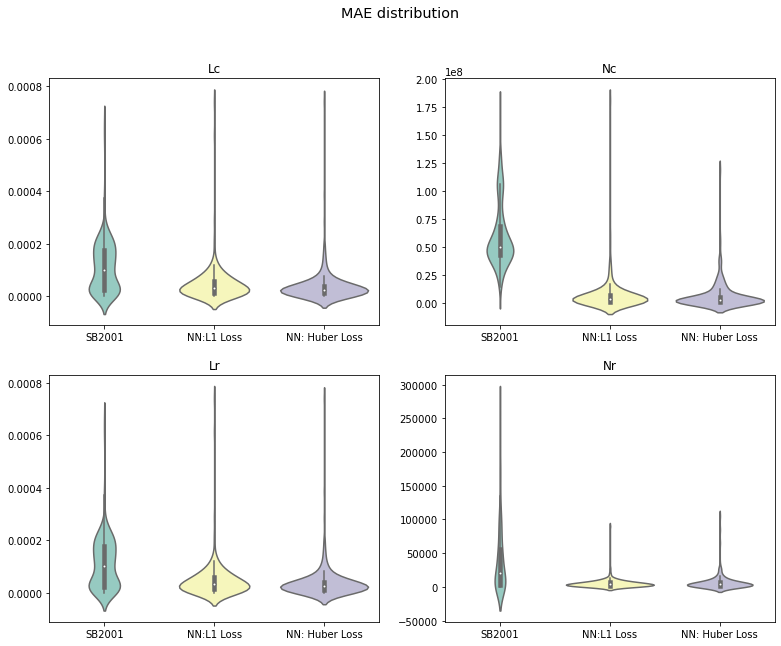

In [68]:
i=0
var=['Lc','Nc','Lr','Nr']
f = plt.figure()
f.set_size_inches([13,10])
for i in range(4):
    ax=f.add_subplot(2, 2, i+1)

    ax=sns.violinplot(data=[mae_sb[:,i],mae_nn[:,i],mae_huber[:,i]],palette="Set3")
    plt.xticks([0, 1, 2], ["SB2001", "NN:L1 Loss","NN: Huber Loss"])
    plt.title(var[i])
    
f.suptitle("MAE distribution", fontsize="x-large")  

Text(0.5, 0.98, 'MAE distribution')

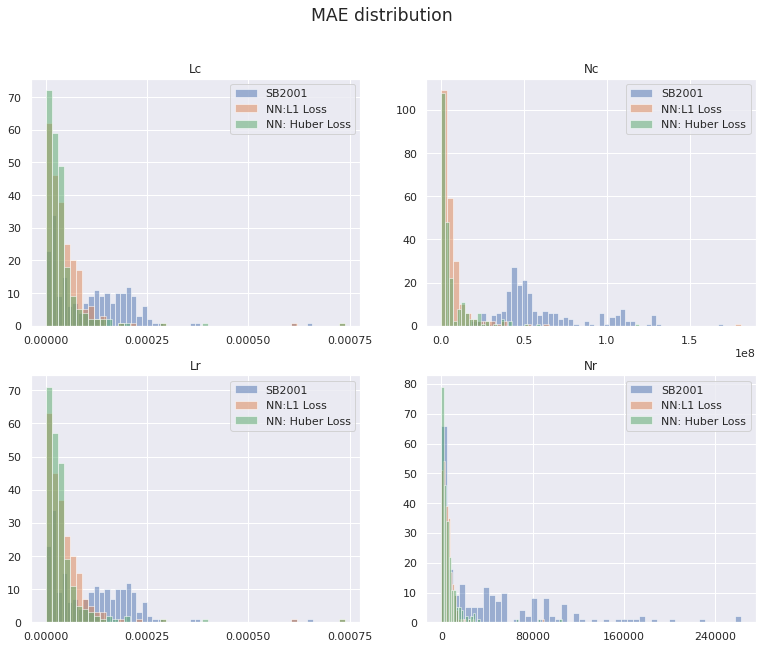

In [131]:
var=['Lc','Nc','Lr','Nr']
f = plt.figure()
f.set_size_inches([13,10])
for i in range(4):
    ax=f.add_subplot(2, 2, i+1)
    plt.hist(mae_sb[:,i], bins=50, alpha=0.5, label="SB2001")
    plt.hist(mae_nn[:,i], bins=50, alpha=0.5, label="NN:L1 Loss")
    plt.hist(mae_huber[:,i], bins=50, alpha=0.5, label="NN: Huber Loss")
 
    plt.legend()
    plt.title(var[i])
    ax.xaxis.set_major_locator(ticker.MaxNLocator(4))
    

f.suptitle("MAE distribution", fontsize="x-large")  


Text(0.5, 0.98, 'MAE distribution')

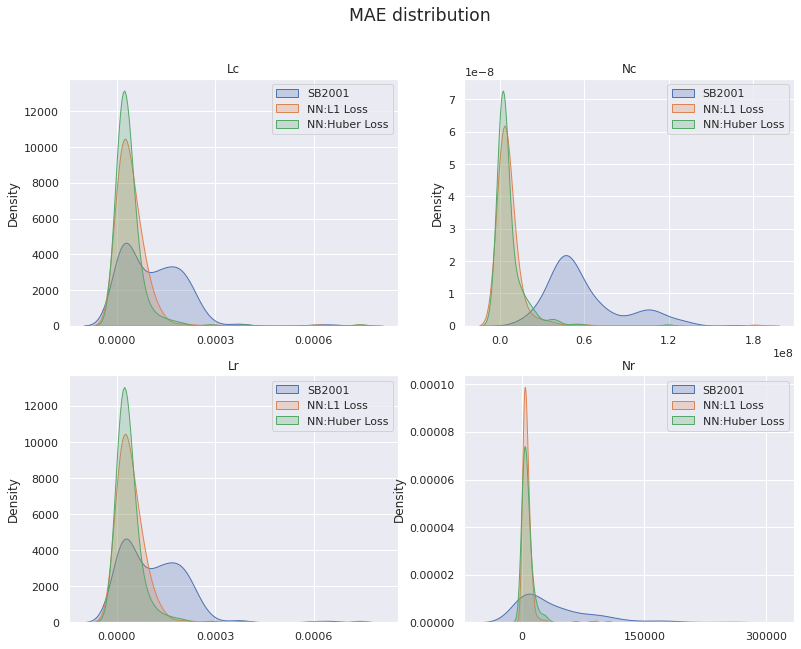

In [134]:
var=['Lc','Nc','Lr','Nr']
f = plt.figure()
f.set_size_inches([13,10])
for i in range(4):
    ax=f.add_subplot(2, 2, i+1)
    g=sns.kdeplot(mae_sb[:,i], shade=True,label="SB2001")
  
    g=sns.kdeplot(mae_nn[:,i], shade=True,label="NN:L1 Loss")
    g=sns.kdeplot(mae_huber[:,i], shade=True,label="NN:Huber Loss")
    plt.legend()
    plt.title(var[i])
    ax.xaxis.set_major_locator(ticker.MaxNLocator(4))
    

f.suptitle("MAE distribution", fontsize="x-large")  

Text(0.5, 0.98, 'R distribution')

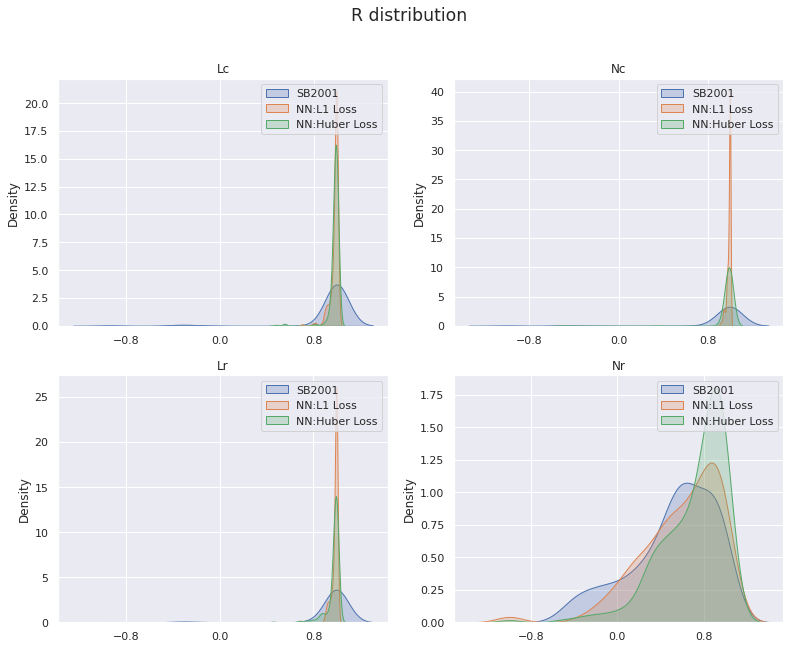

In [133]:
var=['Lc','Nc','Lr','Nr']
f = plt.figure()
f.set_size_inches([13,10])
for i in range(4):
    ax=f.add_subplot(2, 2, i+1)
    g=sns.kdeplot(corr_sb[:,i], shade=True,label="SB2001")
    g=sns.kdeplot(corr_nn[:,i], shade=True,label="NN:L1 Loss")
    g=sns.kdeplot(corr_huber[:,i], shade=True,label="NN:Huber Loss")
    plt.legend()
    plt.title(var[i])
    ax.xaxis.set_major_locator(ticker.MaxNLocator(4))
    

f.suptitle("R distribution", fontsize="x-large")  


Text(0.5, 0.98, 'R distribution')

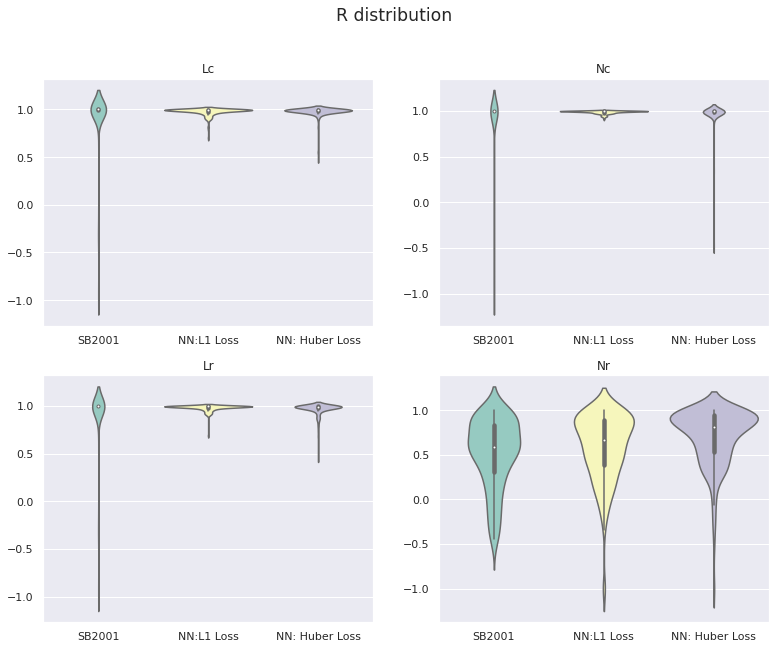

In [105]:
i=0
var=['Lc','Nc','Lr','Nr']
f = plt.figure()
f.set_size_inches([13,10])
for i in range(4):
    ax=f.add_subplot(2, 2, i+1)

    ax=sns.violinplot(data=[corr_sb[:,i],corr_nn[:,i],corr_huber[:,i]],palette="Set3")
    plt.xticks([0, 1, 2], ["SB2001", "NN:L1 Loss","NN: Huber Loss"])
    plt.title(var[i])
    
f.suptitle("R distribution", fontsize="x-large")  

Text(0.5, 0.98, 'R distribution')

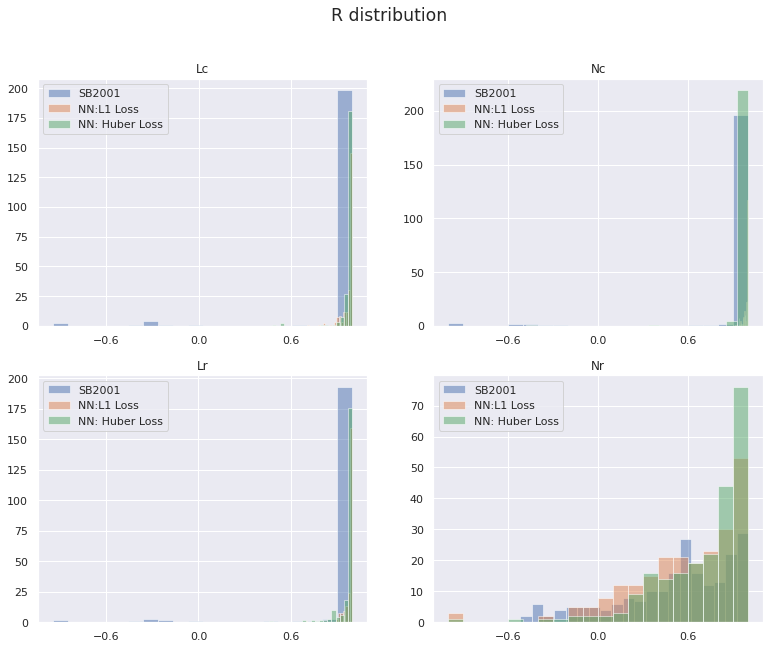

In [145]:
var=['Lc','Nc','Lr','Nr']
f = plt.figure()
f.set_size_inches([13,10])
n_bins=20
for i in range(4):
    ax=f.add_subplot(2, 2, i+1)
    plt.hist(corr_sb[:,i], bins=n_bins, alpha=0.5, label="SB2001")
    plt.hist(corr_nn[:,i], bins=n_bins, alpha=0.5, label="NN:L1 Loss")
    plt.hist(corr_huber[:,i], bins=n_bins, alpha=0.5, label="NN: Huber Loss")
 
    plt.legend()
    plt.title(var[i])
    ax.xaxis.set_major_locator(ticker.MaxNLocator(4))
    

f.suptitle("R distribution", fontsize="x-large")  
